[*********************100%***********************]  6 of 6 completed


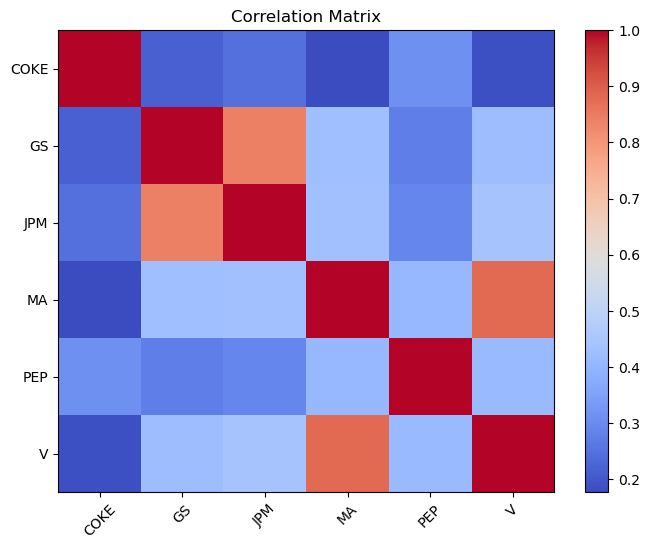

In [84]:
#Step 1 finding correlation between stocks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
# @title
# Importing data manipulation modules
import pandas as pd
import numpy as np

# Importing data visulations modules
import matplotlib.pyplot as plt

# Importing finance modules
import yfinance as yf
# Ticker list to download
tickers = 'V MA PEP COKE GS JPM' # Why would we use these instead of just company names?

# Download data from Yahoo-Finance
data = yf.download(
    tickers = tickers, # The stocks do we want to get
    interval = "1d", # The sample rate of the data
    start="2010-01-01", # From what point do we want to start getting stock data
    end="2024-04-30", # From what point do we want to stop getting stock data
    ignore_tz=True,
    auto_adjust=True, # Adjust all fields by splits and dividends
)
df = data['Close'].copy()
df = df.pct_change()
df = df.fillna(0)

monthly_ret = df.resample('M')
monthly_ret = monthly_ret.apply(lambda x: (1 + x).prod() - 1)


# Calculate the correlations between all the monthly returns of stocks with eachother
correlations = monthly_ret.corr()

# ** Code to Display Heat Map **

plt.figure(figsize=(8, 6))
plt.imshow(correlations, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()

# Add labels for the axes
tick_marks = np.arange(len(correlations.columns))
plt.xticks(tick_marks, correlations.columns, rotation=45)
plt.yticks(tick_marks, correlations.columns)

plt.title('Correlation Matrix')
plt.show()

In [85]:
# Clearly from this matrix, we can see Mastercard and Visa are correlated 


In [86]:
tickers = "MA V"
#tickers = "PEP COKE"
#tickers = "GS JPM"
data = yf.download(
    tickers = tickers,
    start="2010-01-01", # From what point do we want to start getting stock data
    end="2024-04-30", # From what point do we want to stop getting stock data
    interval = "1d", # The sample rate of the data one stock data every day
    ignore_tz=True,
    auto_adjust=True, # Adjust all fields by splits and dividends
)
data = data['Close'].copy()
#data["V"] = data["COKE"]
#data["MA"] = data["PEP"]
#data["V"] = data["GS"]
#data["MA"] = data["JPM"]

[*********************100%***********************]  2 of 2 completed


In [87]:
px.line(100*(data["V"])) 
px.line(100*(data["MA"]))


In [88]:
data["Spread"] = data["MA"]/data["V"]

#data["Mean Spread"] = data["Spread"].expanding().mean().fillna(1.5)
#data["Standard Deviation"] = data["Mean Spread"].expanding().std().fillna(1)

data["Mean Spread"] = data["Spread"].rolling(window=10).mean().fillna(1.5)
data["Standard Deviation"] = data["Mean Spread"].rolling(window=10).std().fillna(1)

data["ZScore"] = (data["Spread"] - data["Mean Spread"])/data["Standard Deviation"]
data['MAdaily_change'] = data["MA"].pct_change().fillna(0.01)
data["Vdaily_change"] = data["V"].pct_change().fillna(0.01)

ZScore = 2
data = data.assign(
    
                    signal =  np.where(data["ZScore"] > ZScore, -1,(np.where(data["ZScore"] < -(ZScore),1,0)))
                )
data['signal'] = data['signal'].shift(1,fill_value = 0)
data['Pairs Trading'] = ((data['MAdaily_change'] - data['Vdaily_change']) * data['signal'])/2 
    
# Get the cumulative product over the 4 years for both our strategy and when we just buy and hold
cumprod_strategy = (1 + data['Pairs Trading']).cumprod()
cumprod_buy_and_hold = (1 + (data['MAdaily_change'] +data['Vdaily_change'])/2).cumprod()
cumprod_signals = pd.DataFrame(dict(
    strategy = cumprod_strategy,
    buy_hold = cumprod_buy_and_hold
))

# Scale our money by the cumulative products
px.line(100 * cumprod_signals)


In [89]:
data

Ticker,MA,V,Spread,Mean Spread,Standard Deviation,ZScore,MAdaily_change,Vdaily_change,signal,Pairs Trading
Date,,,,,,,,,,
2010-01-04 00:00:00+00:00,23.753677,19.785189,1.200579,1.500000,1.000000,-0.299421,0.010000,0.010000,0,0.0
2010-01-05 00:00:00+00:00,23.683392,19.558474,1.210902,1.500000,1.000000,-0.289098,-0.002959,-0.011459,0,0.0
2010-01-06 00:00:00+00:00,23.649151,19.295832,1.225609,1.500000,1.000000,-0.274391,-0.001446,-0.013429,0,0.0
2010-01-07 00:00:00+00:00,23.494606,19.475424,1.206372,1.500000,1.000000,-0.293628,-0.006535,0.009307,0,-0.0
2010-01-08 00:00:00+00:00,23.502939,19.529291,1.203471,1.500000,1.000000,-0.296529,0.000355,0.002766,0,-0.0
...,...,...,...,...,...,...,...,...,...,...
2024-04-23 00:00:00+00:00,461.521851,272.537933,1.693422,1.695042,0.009324,-0.173681,0.013290,0.006536,0,0.0
2024-04-24 00:00:00+00:00,461.202759,273.442688,1.686652,1.692273,0.009590,-0.586064,-0.000691,0.003320,0,-0.0
2024-04-25 00:00:00+00:00,460.813843,273.581940,1.684372,1.690335,0.009382,-0.635511,-0.000843,0.000509,0,-0.0
